In [2]:
from matplotlib import pyplot as plt
import torch
from tqdm import tqdm
from sklearn.datasets import make_blobs
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

if torch.cuda.is_available():
    print("GPU is available")
    import cupy as np
else:
    print("GPU is not available")
    import numpy as np

GPU is not available


In [4]:
import sys
np.set_printoptions(threshold=sys.maxsize)
class BBG:
	def __init__(self, points: np.ndarray=None):
		self.points = points
		self.distances = BBG.get_euclidean_distances(points)

	# algo 1: wavg is known
	def run_1(self, alpha: float=1.0, epsilon: float=0.1, k: int=1, w_avg: float=1.0):
		tau = 0.2 * ((alpha * w_avg) / epsilon)
		b = (1 + 5/alpha)*epsilon*len(self.points)
		# set all distances greater than tau to 0
		tau_neighbors = np.where(self.distances < tau, 1, 0)
		# find the number of shared neighbors between each pair of points
		H = np.matmul(tau_neighbors, np.transpose(tau_neighbors))
		# set all values in H greater than b to 1
		H = np.where(H >= b, 1, 0)
		connected_components = BBG.find_components(H)
		top_k_component_indices = BBG.get_topk_components(connected_components, k)
		top_k_components = [connected_components[i] for i in top_k_component_indices]
		clusters = BBG.label_points(self.distances, top_k_components)
		return clusters

		
	
	#mxn matrix -> m points, each are in R^n. 
	def run_2(self, points: np.ndarray, k: int=-1):
		m = points.shape[0]
		n = points.shape[1]
		print("b condition: ", (1 + 5/self.alpha)*self.epsilon*m)
		print("total points condition: ", m*(1 - self.epsilon - 5*self.epsilon/self.alpha))
		distances = BBG.get_euclidean_distances(points)
		sorted_distances = np.sort(np.unique(np.ravel(distances)))
		prev_min_num_points_in_component = 0
		prev_top_k_components = []
		prev_num_components = 0
	
		for idx in tqdm(range(0, len(sorted_distances), max(len(sorted_distances)//5000, 1))):
			tau = sorted_distances[idx]
			if(tau == 0):
				continue
			tau_neighbors = np.where(distances < tau, 1, 0) 
			b = (1 + 5/self.alpha)*self.epsilon*m
			H = np.matmul(tau_neighbors, np.transpose(tau_neighbors))
			H = np.where(H >= b, 1, 0) # H contains the number of shared neighbors between each pair of points
			connected_components = BBG.find_components(H)
			top_k_component_indices = BBG.get_topk_components(connected_components, k)
			top_k_components = [connected_components[i] for i in top_k_component_indices]
			# print("tau: ", tau, " num components: ", len(top_k_components), "components: ", top_k_components)
			total_points_in_all_components = sum(list(map(lambda x: len(x), top_k_components)))
			min_num_points_in_component = min(list(map(lambda x: len(x), top_k_components))
			)
			# if epoch % 100 == 0:
			# 	# print("epoch: ", epoch, "tau: ", tau,)
			# 	# print("num points in each component: ", list(map(lambda x: len(x), top_k_components)))
			# 	# print("total points in all components: ", total_points_in_all_components)
			# 	# print("min num points in component: ", min_num_points_in_component)
			# epoch += 1
			
			# can we run the last step?
			if min_num_points_in_component > b and total_points_in_all_components >= m*(1 - self.epsilon - 5*self.epsilon/self.alpha):
				print("stop early")
				print("best tau: ", tau)
				break
			# detect cluster merging
			if min_num_points_in_component > prev_min_num_points_in_component and len(top_k_components) < prev_num_components:
				print("cluster merging")
				print("best tau: ", tau)
				min_num_points_in_component = prev_min_num_points_in_component
				top_k_components = prev_top_k_components
				break
			prev_min_num_points_in_component = min_num_points_in_component
			prev_top_k_components = top_k_components
			prev_num_components = len(top_k_components)
		
		print("top_k_components final: ", top_k_components)
		clusters = BBG.label_points(distances, top_k_components)
		return clusters
		

	@staticmethod
	def label_points(distances, clusters):
		# distances is an mxm matrix where the (i,j) index contains the distance from point i to point j
		# clusters is a list of lists of indices where each list of indices represents a cluster
		# returns a list of labels of size m where the ith index contains the label of point i according to the 
		# minimum median distance from point i to all other points in each cluster
		labels = np.zeros(len(distances))
		for i in range(len(distances)):
			min_median = float('inf')
			for cluster_index, cluster in enumerate(clusters):
				median = np.median(distances[i][cluster])
				if median < min_median:
					min_median = median
					labels[i] = cluster_index
		return labels


		

	@staticmethod
	def find_components(H: np.ndarray): 
		# H is a mxm adjacency matrix where the (i,j) index = 1 if point i and point j are connected, 0 otherwise
		# returns a list of lists of indices where each list of indices represents a connected component
		H = csr_matrix(H)
		num_components, labels = connected_components(csgraph=H, directed=False, return_labels=True)
		components = []
		for i in range(num_components):
			components.append(np.argwhere(labels == i))
		return components

		# visited = [False]*len(H)
		# components = []
		# for i in range(len(H)):
		# 	if visited[i]:
		# 		continue
		# 	stack = [i]
		# 	component = []
		# 	while len(stack) != 0:
		# 		curr = stack.pop()
		# 		if visited[curr]:
		# 			continue
		# 		visited[curr] = True
		# 		component.append(curr)
		# 		stack.extend(list(np.ravel(np.argwhere(H[curr]))))
		# 	components.append(component)
		# return components

	@staticmethod
	def get_euclidean_distances(points: np.ndarray): 
		# points is a array of points where each point is a list of coordinates
		# returns a mxm symmetric matrix where the (i,j) index contains the distance from point i to point j
		return np.linalg.norm(points - points[:, None], axis=-1)




	@staticmethod
	def get_topk_components(components, k):
		#components is a np list of lists of indices.
		#k is the number of components to return
		#returns the top k components by size
		# map the length of each component to its index
		sizes = np.array(list(map(lambda x: len(x), components)))
		k = min(k, len(components))
		return np.argpartition(sizes, -k)[-k:]


In [5]:
import itertools


def get_max_eps(alpha, min_cluster_size, n):
    return (min_cluster_size - 2) / ((3 + 10/alpha)*n)

def get_accuracy(labels, true_labels, points, k):
		# get median of each label
		medoids = []
		for label in range(k):
			medoid = np.median(points[np.where(labels == label)], axis=0)
			# account for case where there are no points in a cluster
			if np.isnan(medoid).any():
				medoid = np.zeros(points.shape[1])
			medoids.append(medoid)
		# get median of each true label
		true_medoids = []
		for label in range(k):
			medoid = np.median(points[np.where(true_labels == label)], axis=0)
			true_medoids.append(medoid)
		# try all possible permutations of relabeling mappings and see which one gives lowest distance to true medoids
		permutations = list(itertools.permutations(range(k)))
		min_dist = float('inf')
		relabel_mapping = None
		for permutation in permutations:
			dist = 0
			for i in range(k):
				dist += np.sqrt(np.sum((medoids[i] - true_medoids[permutation[i]])**2))
			if dist < min_dist:
				min_dist = dist
				relabel_mapping = permutation
		# print("relabel mapping: ", relabel_mapping)
		# get accuracy of points according to relabel mapping
		# get relabeled labels
		for i in range(len(labels)):
			labels[i] = relabel_mapping[int(labels[i])]
		accuracy = 0
		for i in range(len(labels)):
			if labels[i] == true_labels[i]:
				accuracy += 1
		return accuracy / len(points), labels

def get_w_avg(x, medians):
	# x is the points
	# medians is the medians of each cluster
	sum_dist = 0
	for i in range(len(x)):
		min_dist = float('inf')
		for j in range(len(medians)):
			dist = np.sqrt(np.sum((x[i] - medians[j])**2))
			if dist < min_dist:
				min_dist = dist
		sum_dist += min_dist
	return sum_dist / len(x)

def get_w_avg_2(x, medians):
	# x is the points
	# medians is the medians of each cluster
	sum_dist = 0
	for i in range(len(x)):
		min_dist = float('inf')
		# get distance to second closest median
		min_dist_2 = float('inf')
		for j in range(len(medians)):
			dist = np.sqrt(np.sum((x[i] - medians[j])**2))
			if dist < min_dist:
				min_dist_2 = min_dist
				min_dist = dist
			elif dist < min_dist_2:
				min_dist_2 = dist
		sum_dist += min_dist_2
	return sum_dist / len(x)

def get_medians(x, labels, k):
	medians = []
	for label in range(k):
		median = np.median(x[np.where(labels == label)], axis=0)
		medians.append(median)
	return medians

def get_normalized_points(x):
	# return normalized points based on mean and std
	normalized_x = np.zeros(x.shape)
	for i in range(x.shape[1]):
		normalized_x[:, i] = (x[:, i] - np.mean(x[:, i])) / np.std(x[:, i])
	return normalized_x


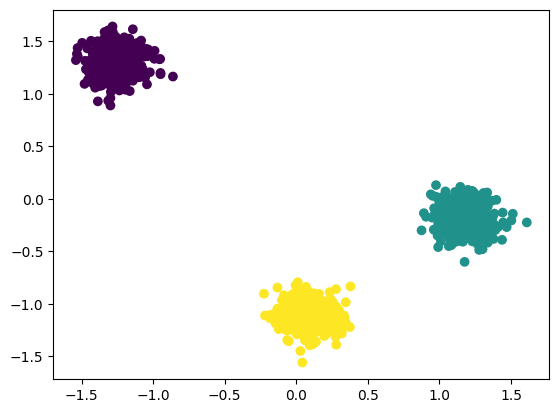

In [10]:
def sample_mnist_clusters(generate_new=False):
    if generate_new:
        !cd mnist && python make_cluster_dataset.py
        !cd ../
    # load in mnist clusters
    x = np.load('./mnist/out/bottleneck_features.npy')
    # x = get_normalized_points(x)
    y = np.load('./mnist/out/labels.npy')

    # map labels to 0-k labels
    label_map = {}
    for i, label in enumerate(np.unique(y)):
        label_map[label] = i
    for i in range(len(y)):
        y[i] = label_map[y[i]]
    return x, y

def sample_synthetic_clusters(num_points, k, std):
    x, y = make_blobs(n_samples=num_points, centers=k, n_features=2, cluster_std=std)
    x = get_normalized_points(x)
    medians = get_medians(x, y, k)
    w_avg = get_w_avg(x, medians)
    return x, y, w_avg

x, y, wa_avg = sample_synthetic_clusters(1000, 3, 0.6)
plt.scatter(x[:,0], x[:,1], c=y)

# # # normalize points with 0-1 scaling
# # x = (x - np.min(x)) / (np.max(x) - np.min(x))
# num_clusters = 3
# true_cluster_size = 200

# x, y = sample_mnist_clusters(generate_new=True)
# # find median of each cluster
# medians = get_media
# # get w_avg
# w_avg = get_w_avg(x, medians)
# print("w_avg: ", w_avg)
# # plot points
# plt.scatter(x[:,0], x[:,1], c=y)
# plt.show()

In [350]:
# Experiment 1: Testing the highest alpha that gives 100% accuracy for varying std
k = 3
true_cluster_size = 200
n = true_cluster_size * k
average_alphas = [] # median alpha at which 100% accuracy is achieved for each std
for std in np.arange(0.1, 1.1, 0.1):
    alpha_sum = 0
    trials = 25
    alphas = []
    for i in tqdm(range(trials)):
        x, y, w_avg = sample_synthetic_clusters(n, k, std)
        bbg = BBG(x)
        max_accuracy = 0
        max_distance = np.max(bbg.distances)
        alpha = 5
        while alpha > 0:
            start_eps = 0.2 * ((alpha * w_avg) / max_distance)
            start_eps = round(start_eps, 2)
            max_eps = get_max_eps(alpha, true_cluster_size, n)
            # print("b range, " , (1+5/alpha)*start_eps*n, (1 + 5/alpha)*max_eps*n)
            # # find start value of epsilon such that tau is less than range of distances
            # # tau = 0.2 * ((alpha * w_avg) / epsilon)
            # # epsilon must satisfy max_distance > tau
            # print("tau range, ", 0.2 * ((alpha * w_avg) / start_eps), 0.2 * ((alpha * w_avg) / max_eps))
            for epsilon in np.arange(start_eps, max_eps + 0.0001, 0.01):
                labels = bbg.run_1(alpha=alpha, epsilon=epsilon, k=k, w_avg=w_avg)
                accuracy, bbg_relabels = get_accuracy(labels, y, x, k)
                if accuracy == 1:
                    max_accuracy = accuracy
                    break
            if max_accuracy == 1:
                break
            alpha -= 0.2
        alphas.append(alpha)
    # remove the top and bottom 2 outliers
    alphas = np.sort(alphas)
    alphas = alphas[2:-2]
    avg = np.mean(alphas)
    average_alphas.append(avg)
    print("std: ", std, " average alpha: ", avg)
# print("best accuracy: ", max_accuracy)
# print("best epsilon: ", best_eps)
# print("best alpha: ", best_alpha)

# # cluster the points with k medioids from sklearn
# from sklearn_extra.cluster import KMedoids
# kmedoids = KMedoids(n_clusters=num_clusters).fit(x)
# sklearn_clusters = kmedoids.labels_
# k_medoids_accuracy, sklearn_relabeled = get_accuracy(sklearn_clusters, y, x, num_clusters)
# print("k_medoids_accuracy: ", k_medoids_accuracy)
# figure, ax = plt.subplots(2, 2)
# # 2x2 grid of plots

# # plot accuracies for the best alpha
# best_start_eps = 0.2 * ((best_alpha * w_avg) / max_distance)
# best_start_eps = round(best_start_eps, 3)
# ax[0, 0].plot(np.arange(best_start_eps, max_eps + 0.0001, .001),  all_accuracies[int(best_alpha*10 - 1)])
# ax[0, 0].set_xlabel("epsilon")
# ax[0, 0].set_ylabel("accuracy")
# ax[0, 0].set_title("Accuracy vs Epsilon")
# # plot points in best cluster
# ax[0, 1].set_title("Balcan Algorithm Clusters")
# ax[0, 1].scatter(x[:, 0], x[:, 1], c=best_clusters)
# # space between first and second row of plots
# plt.subplots_adjust(hspace=0.5)

# ax[1, 0].scatter(x[:, 0], x[:, 1], c=sklearn_relabeled)
# ax[1, 0].set_title("K Medoids Clusters")
# # plot points with true labels
# ax[1, 1].scatter(x[:, 0], x[:, 1], c=y)
# ax[1, 1].set_title("True Clusters")
# plt.show()


  0%|          | 0/25 [00:00<?, ?it/s]/Users/shikh/.pyenv/versions/3.9.1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shikh/.pyenv/versions/3.9.1/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
 12%|█▏        | 3/25 [00:01<00:10,  2.04it/s]/var/folders/65/jsg2nfnn7_s9qm11fwrxs10r0000gp/T/ipykernel_13736/1966500051.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  tau = 0.2 * ((alpha * w_avg) / epsilon)
100%|██████████| 25/25 [00:29<00:00,  1.20s/it]


std:  0.1  average alpha:  5.0


100%|██████████| 25/25 [01:53<00:00,  4.53s/it]


std:  0.2  average alpha:  3.9809523809523806


100%|██████████| 25/25 [01:57<00:00,  4.72s/it]


std:  0.30000000000000004  average alpha:  3.3619047619047615


100%|██████████| 25/25 [03:13<00:00,  7.75s/it]


std:  0.4  average alpha:  1.3428571428571408


100%|██████████| 25/25 [02:46<00:00,  6.68s/it]


std:  0.5  average alpha:  1.2190476190476172


100%|██████████| 25/25 [03:26<00:00,  8.28s/it]


std:  0.6  average alpha:  0.33333333333333115


100%|██████████| 25/25 [02:34<00:00,  6.20s/it]


std:  0.7000000000000001  average alpha:  0.09523809523809305


100%|██████████| 25/25 [02:49<00:00,  6.79s/it]


std:  0.8  average alpha:  -2.1649348980190553e-15


100%|██████████| 25/25 [01:57<00:00,  4.68s/it]


std:  0.9  average alpha:  -2.1649348980190553e-15


100%|██████████| 25/25 [01:36<00:00,  3.85s/it]

std:  1.0  average alpha:  -2.1649348980190553e-15


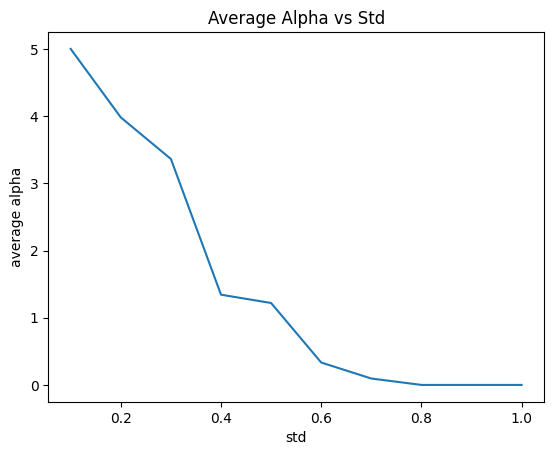

In [390]:
# graph average alpha vs std
plt.plot(np.arange(0.1, 1.1, 0.1), average_alphas)
plt.xlabel("std")
plt.ylabel("average alpha")
plt.title("Average Alpha vs Std")
plt.show()

/var/folders/65/jsg2nfnn7_s9qm11fwrxs10r0000gp/T/ipykernel_13736/46180048.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 0.5], [125, 125], 'k--', lw=1, color='red')
/var/folders/65/jsg2nfnn7_s9qm11fwrxs10r0000gp/T/ipykernel_13736/46180048.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 0.5], [250, 250], 'k--', lw=1, color='red')
/var/folders/65/jsg2nfnn7_s9qm11fwrxs10r0000gp/T/ipykernel_13736/46180048.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 0.5], [500, 500], 'k--', lw=1, color='red')
/var/folders/65/jsg2nfnn7_s9qm11fwrxs10r0000gp/T/ipykernel_13736/46180048.py:21: UserWarning: color is red

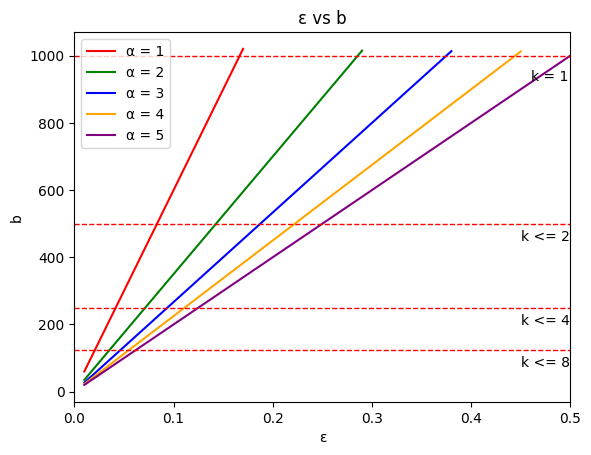

In [389]:
# Analysis: Alpha vs B and Epsilon
n = 1000
c=['red', 'green', 'blue', 'orange', 'purple']
for alpha in np.arange(1, 5.1, 1):
    b_values = []
    epsilon_values = []
    # find max_eps where b = 1000
    max_eps = 1025 / ((1 + 5/alpha)*n)
    for epsilon in np.arange(0.01, max_eps + 0.001, 0.01):
        b = (1 + 5/alpha)*epsilon*n
        b_values.append(b)
    plt.plot(np.arange(0.01, max_eps + 0.001, 0.01), b_values, c=c[int(alpha - 1)])
plt.xlabel("ε")
plt.ylabel("b")
plt.title("ε vs b")
plt.legend(["α = 1", "α = 2", "α = 3", "α = 4", "α = 5"])
# put markers at b = 125, 250, 500, 1000
plt.plot([0, 0.5], [125, 125], 'k--', lw=1, color='red')
plt.plot([0, 0.5], [250, 250], 'k--', lw=1, color='red')
plt.plot([0, 0.5], [500, 500], 'k--', lw=1, color='red')
plt.plot([0, 0.5], [1000, 1000], 'k--', lw=1, color='red')
# labels
plt.text(0.45, 75, "k <= 8")
plt.text(0.45, 200, "k <= 4")
plt.text(0.45, 450, "k <= 2")
plt.text(0.46, 925, "k = 1")
# set width of image
plt.xlim([0, 0.5])
plt.show()


accuracy:  0.855
k_medoids_accuracy:  0.9616666666666667


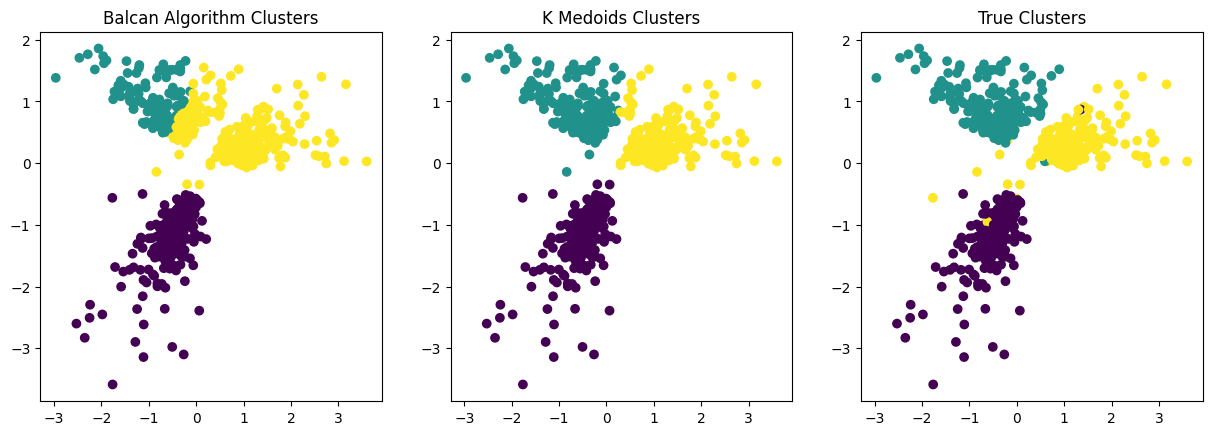

In [202]:
# !cd mnist && python make_cluster_dataset.py
# !cd ../
# x, y = sample_mnist_clusters()

# # run balcan algorithm on mnist clusters
# bbg = BBG(points=x)
# labels = bbg.run_1(alpha=best_alpha, epsilon=best_eps, k=num_clusters, w_avg=w_avg)
# accuracy, bbg_relabels = get_accuracy(labels, y, x, num_clusters)
# print("accuracy: ", accuracy)

# # run k medoids on mnist clusters
# kmedoids = KMedoids(n_clusters=num_clusters).fit(x)
# sklearn_clusters = kmedoids.labels_
# k_medoids_accuracy, sklearn_relabeled = get_accuracy(sklearn_clusters, y, x, num_clusters)
# print("k_medoids_accuracy: ", k_medoids_accuracy)
# # plot points
# figure, ax = plt.subplots(1, 3)
# # set width of figure
# figure.set_figwidth(15)
# ax[0].scatter(x[:, 0], x[:, 1], c=bbg_relabels)
# ax[0].set_title("Balcan Algorithm Clusters")
# ax[1].scatter(x[:, 0], x[:, 1], c=sklearn_relabeled)
# # ax[1].set_title("K Medoids Clusters")
# ax[2].scatter(x[:, 0], x[:, 1], c=y)
# ax[2].set_title("True Clusters")
# plt.show()


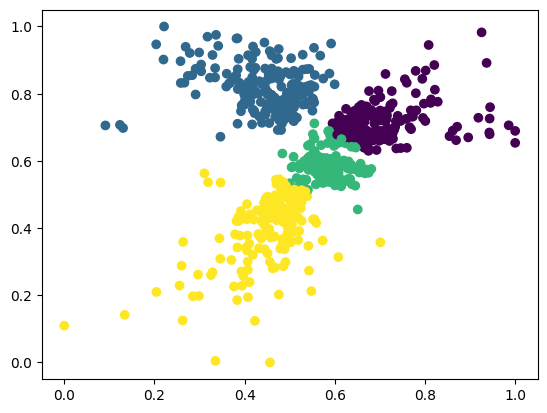

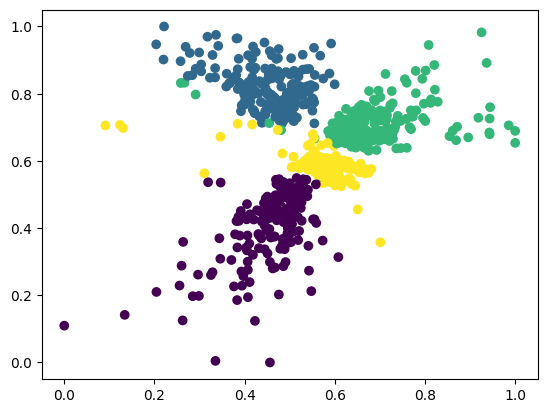

In [59]:
# from sklearn_extra.cluster import KMedoids

# kmedoids = KMedoids(n_clusters=4, random_state=0).fit(points)
# labels = kmedoids.labels_

# our_figure, our_axes = plt.subplots(1)
# our_axes.scatter(points[:, 0], points[:, 1], c=labels)

# true_figure, true_axes = plt.subplots(1)
# true_axes.scatter(points[:, 0], points[:, 1], c=true_labels)